In [1]:
from torchvision.datasets import USPS
from torchvision import transforms

transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])  # 转换为Tensor, 并缩放到32x32, 以便于LeNet5模型处理

train_dataset = USPS(root='USPS/train', train=True, transform=transform, download=True)  # 下载训练集, 并进行转换
test_dataset = USPS(root='USPS/test', train=False, transform=transform, download=True)  # 下载测试集, 并进行转换


In [2]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class USPostalDataset(Dataset):
    """读取数据集"""
    def __init__(self, root_dir, train=True, transform=None):
        self.root_dir = root_dir
        self.train = train
        self.transform = transform

        if self.train:
            self.data_dir = os.path.join(self.root_dir, 'train')
        else:
            self.data_dir = os.path.join(self.root_dir, 'test')

        self.imgs = []
        self.labels = []

        for label in os.listdir(self.data_dir):
            label_dir = os.path.join(self.data_dir, label)
            for img_name in os.listdir(label_dir):
                self.imgs.append(os.path.join(label_dir, img_name))
                self.labels.append(int(label))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        image = Image.open(img_path).convert('L')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

def display_dataset_info(dataset):
    """显示数据集信息"""
    print(f"Number of samples: {len(dataset)}")
    print(f"Number of classes: 10")
    print(f"Image size: {dataset[0][0].shape}")


display_dataset_info(train_dataset)
display_dataset_info(test_dataset)


Number of samples: 7291
Number of classes: 10
Image size: torch.Size([1, 32, 32])
Number of samples: 2007
Number of classes: 10
Image size: torch.Size([1, 32, 32])


In [3]:
import torch.nn as nn
import torch.nn.functional as F


class LeNet5Model(nn.Module):
    """LeNet5 CNN模型
    包含:
    - 两个卷积层:Conv2d(1, 6, 5), Conv2d(6, 16, 5)
    - 两个池化层:MaxPool2d(kernel_size=2, stride=2)
    - 三个全连接层:Linear(16 * 5 * 5, 120), Linear(120, 84), Linear(84, 10)
    - Dropout with drop rate of 0.5
    - ReLU激活函数
    """
    def __init__(self, activation='relu', drop_rate=0.5):
        super(LeNet5Model, self).__init__()
        self.activation = activation
        self.drop_rate = drop_rate

        # 两个卷积层
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # 两个池化层
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)

        # 三个全连接层
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # self.softmax = nn.Softmax(dim=1)

        # Dropout层
        self.dropout = nn.Dropout(self.drop_rate)

        # 选择激活函数
        if activation == 'relu':
            self.act = nn.ReLU()
        if activation == 'leaky_relu':
            self.act = nn.LeakyReLU()
        if activation == 'sigmoid':
            self.act = nn.Sigmoid()

    def forward(self, x):
        # 第一个卷积层
        x = self.act(self.conv1(x))
        # 第一个池化层
        x = self.pool1(x)
        # 第二个卷积层
        x = self.act(self.conv2(x))
        # 第二个池化层
        x = self.pool2(x)

        # 展平层
        x = x.view(-1, 16 * 5 * 5)

        # 第一个全连接层
        x = self.act(self.fc1(x))
        # 第一个dropout层
        x = self.dropout(x)
        # 第二个全连接层
        x = self.act(self.fc2(x))
        # 第三个全连接层
        x = self.fc3(x)
        # softmax层
        # x = self.softmax(x)

        return x


In [4]:
import time
import torch.optim as optim
import matplotlib.pyplot as plt

def train(model, dataloader, criterion, optimizer, device, loss_function):
    """训练函数
    参数:
     - model: 模型
     - dataloader: 训练集dataloader
     - criterion: 损失函数
     - optimizer: 优化器
     - device: 训练设备
     - loss_function: 损失函数类型
    """
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (imgs, labels) in enumerate(dataloader):
        # 将输入和目标载入到设备device
        imgs, labels = imgs.to(device), labels.to(device)

        # 如果损失函数是mse，进行独热编码
        if loss_function == 'mse':
            labels = F.one_hot(labels, num_classes=10).float()
            labels = torch.argmax(labels, dim=1)

        # 梯度清零
        optimizer.zero_grad()
        # 前向传播
        outputs = model(imgs)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 梯度更新
        optimizer.step()

        train_loss += loss.item()
        # 计算正确预测的数量
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        train_acc = 100. * correct / total
        # # 打印训练精度
        # print(f'Accuracy: {train_acc}%')
    return train_loss / (batch_idx + 1), train_acc


def test(model, dataloader, criterion, device, loss_function):
    """测试函数
    参数:
     - model: 模型
     - dataloader: 测试集dataloader
     - criterion: 损失函数
     - device: 训练设备
    """
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(dataloader):
            # 将输入和目标载入到设备device
            imgs, labels = imgs.to(device), labels.to(device)
            if loss_function == 'mse':
                labels = F.one_hot(labels, num_classes=10).float()
            # 前向传播
            outputs = model(imgs)
            # 计算损失
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            # 计算正确预测的数量
            _, predicted = outputs.max(1)
            total += labels.size(0)
            if loss_function == 'mse':
                labels = torch.argmax(labels, dim=1)
            correct += predicted.eq(labels).sum().item()  # 预测正确的数量
            test_acc = 100. * correct / total
            # 打印测试精度
            # print(f'Accuracy: {test_acc}%')
    return test_loss / (batch_idx + 1), test_acc


def plot_training_loss_and_acc(training_losses, training_accuracies, num_epochs):
    """绘制训练loss和精度曲线"""
    epochs = list(range(1, num_epochs + 1))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracies, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [5]:
class EarlyStopping:
    """早停法
    参数:
     - patience: 容忍epoch数
     - delta: 阈值
    """
    def __init__(self, patience=2, delta=0.0001):
        self.patience = patience
        self.delta = delta
        self.best_loss = float("inf")  # 设置初始最优损失为无穷大
        self.counter = 0  # 记录当前epoch数

    def check(self, loss):
        """检查是否需要早停"""
        if self.best_loss - loss > self.delta:  # 如果损失降低
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:  # 如果损失连续patience个epoch没有降低
                return True
        return False


In [6]:
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")  # 设置训练设备

def train_lenet5_model(activation='relu', loss_function='ce',
                       num_epochs=30, batch_size=64, learning_rate=0.001,
                       dropout_rate=0.5, patience=3):
    """训练 LeNet5 模型
    参数:
     - activation: 激活函数类型
     - loss_function: 损失函数类型
     - num_epochs: 训练周期数
     - batch_size: 批量大小
     - learning_rate: 学习率
     - dropout_rate: Dropout 比率
     - patience: 早停法的 patience 值
    """

    # 数据加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 模型初始化
    model = LeNet5Model(activation=activation, drop_rate=dropout_rate).to(device)

    criterion = nn.CrossEntropyLoss()  # 设置损失函数默认为交叉熵损失函数
    if loss_function == 'ce':  # 交叉熵损失函数
        pass
    if loss_function == 'mse':  # 均方误差损失函数
        criterion = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam优化器
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # 学习率衰减

    # 跟踪训练loss和精度
    train_losses = []
    train_accuracies = []

    start_time = time.time()

    # 早停法监测器
    early_stopper = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        print('-' * 50)
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device, loss_function)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f},  Accuracy: {train_accuracy:.2f}%")
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        if (epoch + 1) % 5 == 0:
            test_loss, test_accuracy = test(model, test_loader, criterion, device, loss_function)
            print(f"Test Loss: {test_loss:.4f}, Test Accuracy:  {test_accuracy:.2f}%")

            # 检查是否early stop
            if early_stopper.check(test_loss):
                print(f"Epoch {epoch + 1}/{num_epochs}: Early stopping.  Best test loss: {early_stopper.best_loss}.")
                num_epochs = epoch + 1
                break

        scheduler.step()

    # 训练总时间
    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f} seconds")

    # 保存模型文件
    torch.save(model.state_dict(), f"LeNet5_{activation}_{loss_function}.pth")

    # 绘制训练loss和精度曲线
    plot_training_loss_and_acc(train_losses, train_accuracies, num_epochs)


--------------------------------------------------
Epoch 1/30, Loss: 1.2359,  Accuracy: 58.76%
--------------------------------------------------
Epoch 2/30, Loss: 0.4562,  Accuracy: 85.65%
--------------------------------------------------
Epoch 3/30, Loss: 0.3597,  Accuracy: 89.26%
--------------------------------------------------
Epoch 4/30, Loss: 0.2859,  Accuracy: 90.93%
--------------------------------------------------
Epoch 5/30, Loss: 0.2621,  Accuracy: 92.32%
Test Loss: 0.2920, Test Accuracy:  92.08%
--------------------------------------------------
Epoch 6/30, Loss: 0.2152,  Accuracy: 93.61%
--------------------------------------------------
Epoch 7/30, Loss: 0.2010,  Accuracy: 93.91%
--------------------------------------------------
Epoch 8/30, Loss: 0.1959,  Accuracy: 94.02%
--------------------------------------------------
Epoch 9/30, Loss: 0.1914,  Accuracy: 93.86%
--------------------------------------------------
Epoch 10/30, Loss: 0.1923,  Accuracy: 94.06%
Test Lo

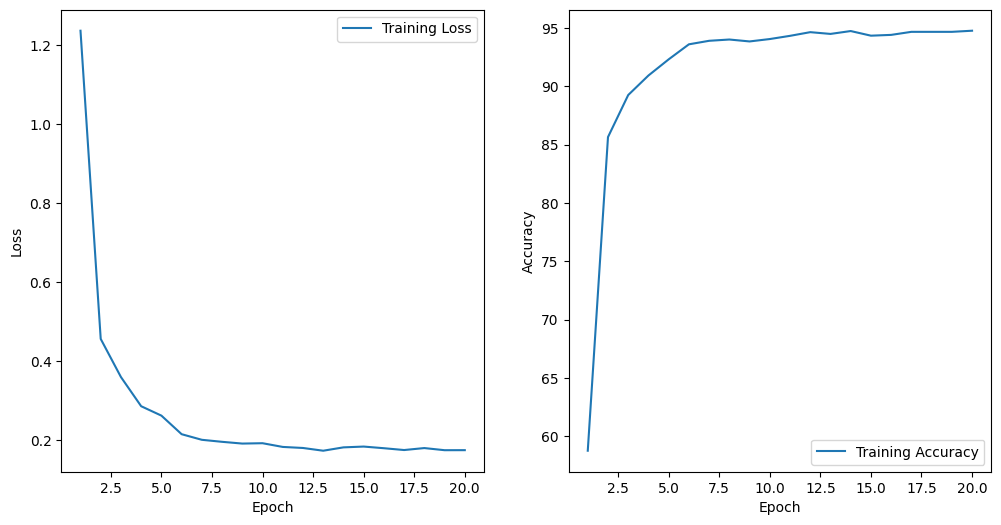

In [11]:
train_lenet5_model(activation='relu', loss_function='ce', num_epochs=30, batch_size=64, learning_rate=0.001, dropout_rate=0.5, patience=2)
# 激活函数为ReLU，交叉熵损失函数，迭代次数为30次，批量大小是64，比较适中，学习率0.001，步长比较小，设置dropout_rate为0.5，比较大，谨防过拟合，早停法的耐心值设为2

第一个模型的设置比较稳妥，采用了都是很保守的参数设置。由于设置的dropout不低，所以模型的训练精度也不会很高，但也正是由于正则化，使得训练精度和测试精度之间并没有太大的差异。本次模型并没有触发早停发，说明模型尚未触发过拟合条件，或许可以尝试加大迭代次数，减小dropout来提升测试精度。


--------------------------------------------------
Epoch 1/30, Loss: 1.2120,  Accuracy: 58.40%
--------------------------------------------------
Epoch 2/30, Loss: 0.3819,  Accuracy: 88.27%
--------------------------------------------------
Epoch 3/30, Loss: 0.2597,  Accuracy: 92.24%
--------------------------------------------------
Epoch 4/30, Loss: 0.2027,  Accuracy: 94.02%
--------------------------------------------------
Epoch 5/30, Loss: 0.1632,  Accuracy: 95.30%
Test Loss: 0.2605, Test Accuracy:  93.27%
--------------------------------------------------
Epoch 6/30, Loss: 0.1345,  Accuracy: 96.01%
--------------------------------------------------
Epoch 7/30, Loss: 0.1219,  Accuracy: 96.57%
--------------------------------------------------
Epoch 8/30, Loss: 0.1107,  Accuracy: 96.80%
--------------------------------------------------
Epoch 9/30, Loss: 0.1111,  Accuracy: 96.76%
--------------------------------------------------
Epoch 10/30, Loss: 0.1058,  Accuracy: 96.83%
Test Lo

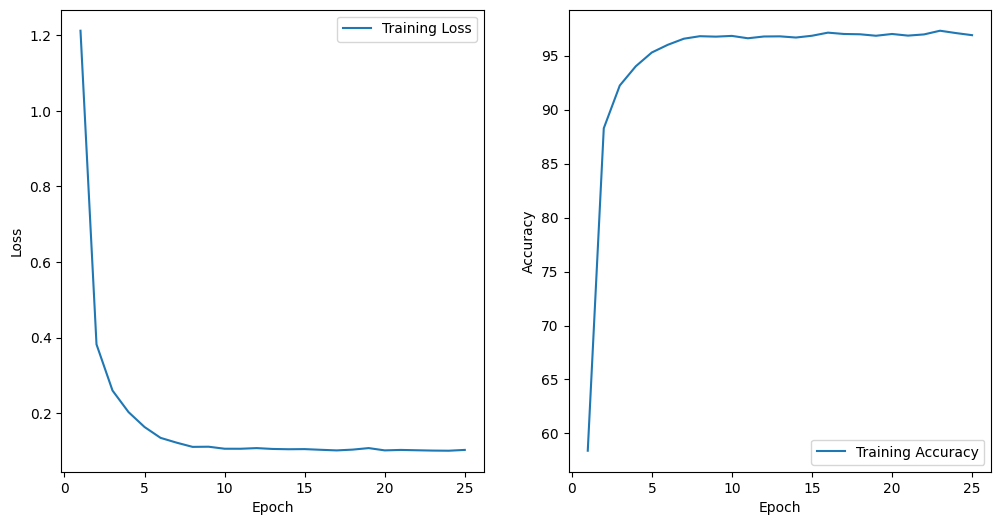

In [8]:
train_lenet5_model(activation='leaky_relu', loss_function='ce', num_epochs=30, batch_size=64, learning_rate=0.001, dropout_rate=0.5, patience=2)

第二个模型与第一个模型仅仅是更换了激活函数，却触发了早停，可以看出leaky_relu在训练精度上有了一定的提升，而测试精度提升不大。考虑继续使用leaky relu

--------------------------------------------------
Epoch 1/30, Loss: 0.4568,  Accuracy: 84.86%
--------------------------------------------------
Epoch 2/30, Loss: 0.1330,  Accuracy: 96.20%
--------------------------------------------------
Epoch 3/30, Loss: 0.0961,  Accuracy: 97.20%
--------------------------------------------------
Epoch 4/30, Loss: 0.0840,  Accuracy: 97.53%
--------------------------------------------------
Epoch 5/30, Loss: 0.0816,  Accuracy: 97.70%
Test Loss: 0.2229, Test Accuracy:  94.42%
--------------------------------------------------
Epoch 6/30, Loss: 0.0329,  Accuracy: 99.03%
--------------------------------------------------
Epoch 7/30, Loss: 0.0186,  Accuracy: 99.38%
--------------------------------------------------
Epoch 8/30, Loss: 0.0143,  Accuracy: 99.66%
--------------------------------------------------
Epoch 9/30, Loss: 0.0107,  Accuracy: 99.77%
--------------------------------------------------
Epoch 10/30, Loss: 0.0105,  Accuracy: 99.71%
Test Lo

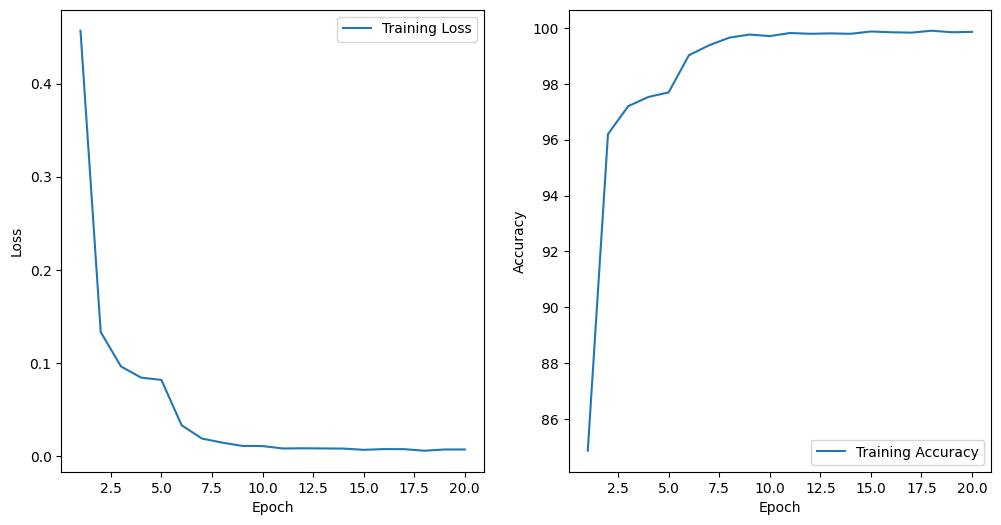

In [9]:
train_lenet5_model(activation='leaky_relu', loss_function='ce', num_epochs=30, batch_size=64, learning_rate=0.01, dropout_rate=0.1, patience=2)


在第三个模型中我们增大了学习率，减小了dropout，由于我们在模型训练函数中设置了学习率衰退，所以我们可以尝试比较大的学习率来加快收敛速度，并减小后期的过拟合风险。可以看出本次训练较早地触发了早停发，收敛速度确实有所提升，而由于dropout的减小，模型的训练精度大大提高（99.86%），同时值得高兴的是测试精度也获得了不小的提升（突破了96.11%），所以我们可以将这个参数设置认为是最好的。（注意，使用同一模型进行训练后，生成的模型文件会替换掉原来的文件）

--------------------------------------------------
Epoch 1/30, Loss: 2.1371,  Accuracy: 20.98%
--------------------------------------------------
Epoch 2/30, Loss: 0.8011,  Accuracy: 72.57%
--------------------------------------------------
Epoch 3/30, Loss: 0.3732,  Accuracy: 88.45%
--------------------------------------------------
Epoch 4/30, Loss: 0.2232,  Accuracy: 93.03%
--------------------------------------------------
Epoch 5/30, Loss: 0.1545,  Accuracy: 95.46%
Test Loss: 0.3124, Test Accuracy:  90.73%
--------------------------------------------------
Epoch 6/30, Loss: 0.0977,  Accuracy: 97.08%
--------------------------------------------------
Epoch 7/30, Loss: 0.0846,  Accuracy: 97.63%
--------------------------------------------------
Epoch 8/30, Loss: 0.0787,  Accuracy: 97.72%
--------------------------------------------------
Epoch 9/30, Loss: 0.0737,  Accuracy: 97.92%
--------------------------------------------------
Epoch 10/30, Loss: 0.0693,  Accuracy: 98.18%
Test Lo

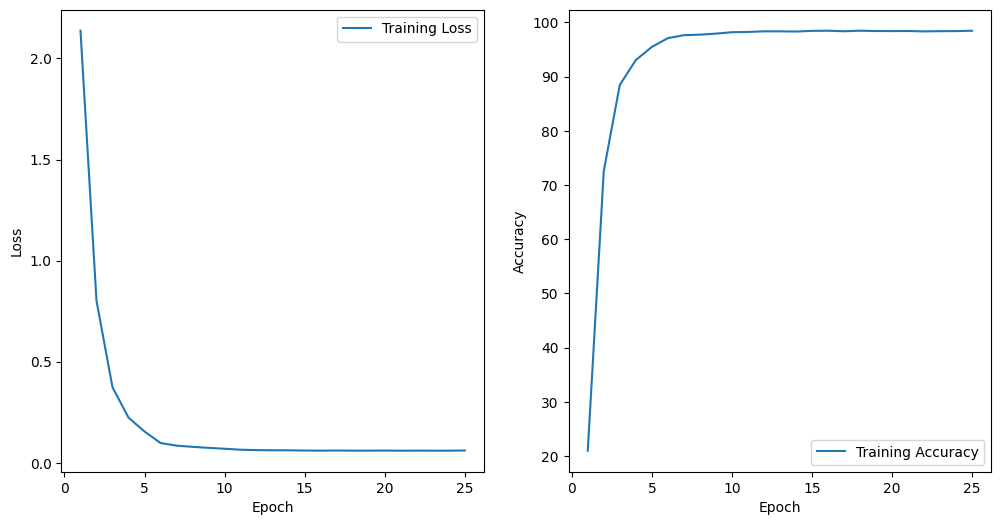

In [13]:
train_lenet5_model(activation='sigmoid', loss_function='ce', num_epochs=30, batch_size=64, learning_rate=0.01, dropout_rate=0.01, patience=2)


这一次采用上次模型的参数，更换激活函数为sigmoid函数。发现dropout设置为0.1时，模型的测试精度比较差（小于90%），所以采用更小的dropout或者不适用dropout。
在设置dropout为0.01后，我们发现测试精度来到了93.52%

--------------------------------------------------
Epoch 1/40, Loss: 0.5487,  Accuracy: 81.81%
--------------------------------------------------
Epoch 2/40, Loss: 0.1292,  Accuracy: 95.98%
--------------------------------------------------
Epoch 3/40, Loss: 0.0976,  Accuracy: 96.87%
--------------------------------------------------
Epoch 4/40, Loss: 0.0773,  Accuracy: 97.81%
--------------------------------------------------
Epoch 5/40, Loss: 0.0723,  Accuracy: 97.92%
Test Loss: 0.2408, Test Accuracy:  94.52%
--------------------------------------------------
Epoch 6/40, Loss: 0.0280,  Accuracy: 99.04%
--------------------------------------------------
Epoch 7/40, Loss: 0.0153,  Accuracy: 99.64%
--------------------------------------------------
Epoch 8/40, Loss: 0.0124,  Accuracy: 99.62%
--------------------------------------------------
Epoch 9/40, Loss: 0.0100,  Accuracy: 99.78%
--------------------------------------------------
Epoch 10/40, Loss: 0.0080,  Accuracy: 99.78%
Test Lo

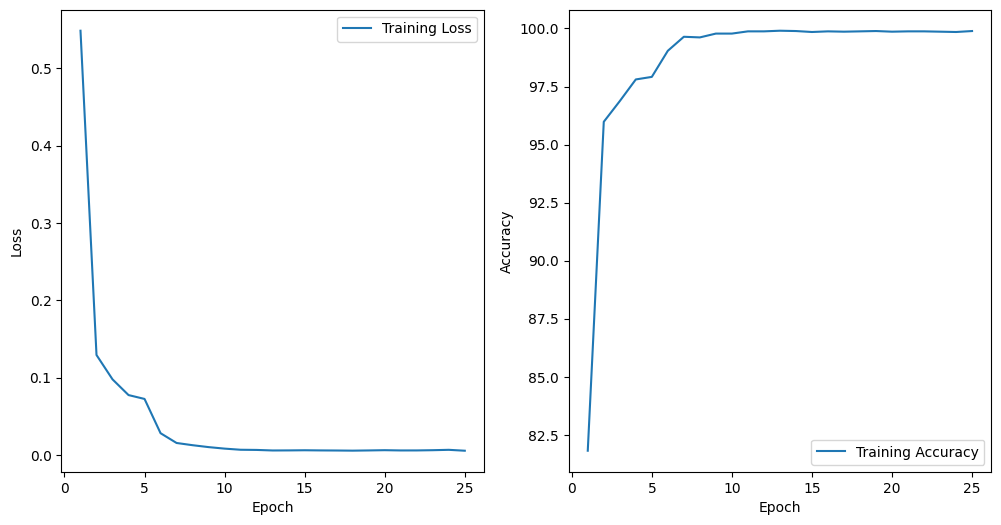

In [22]:
train_lenet5_model(activation='relu', loss_function='ce', num_epochs=40, batch_size=64, learning_rate=0.01, dropout_rate=0.01, patience=3)

#### 在经过多次调参后，我们发现dropout设置为0时，甚至没有设置为0.01训练精度高，另外对于批量大小的设定，大批量速度会降低，小批量精度会降低，而有意思的是，我将批量设置为32或者64是比16要更好的，这有可能是因为触发了过拟合。
设置32＋0.01+0.01得到95.52的精度
设置64+0.01+0.01得到96.26的精度